## Settings Google ngrams

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "arial"
import random
import scipy.stats

### Standardization methods ngrams

In [2]:
# different methods we tried/ are using 
methods=['raw', 'scaled', 'mean', 'max1','01', 'z']
method_titles=['Raw freq', 'Relative freq', 'Rel freq standardized', 'Rel freq max 1','Rel freq min 0, max 1', 'Rel freq z-score']

### Corpora ngrams

In [3]:
# different corpora we are using
corpora = ['eng_all', 'eng_fic','eng_excl_fic','eng_am','ger','sp', 'eng_all_2009', 'eng_fic_2009','eng_excl_fic_2009']
languages = ['eng', 'eng', 'eng', 'eng', 'ger', 'sp', 'eng', 'eng', 'eng']
rmwords = []
scaleword=[]
for lan in languages:
    if lan == 'eng':
        rmwords.append(['war', 'date'])
        scaleword.append('an')
    elif lan == 'ger':
        rmwords.append(['krieg'])
        scaleword.append('ein')
    elif lan == 'sp':
        rmwords.append(['guerra'])
        scaleword.append('la')
    else:
        print('Language: ', lan, ' unknown')
titles = ['English All','English Fiction','English excl Fiction','American English','German','Spanish', 'English All 2009','English Fiction 2009','English excl Fiction 2009']
categories = pd.DataFrame(
    {'corpora': corpora,
     'lan': languages,
     'rmwords' : rmwords,
     'scaleword': scaleword,
     'title': titles})
lans_unique = categories['lan'].unique()
categories = categories.set_index('corpora')
categories

,lan,rmwords,scaleword,title
corpora,,,,
eng_all,eng,"[war, date]",an,English All
eng_fic,eng,"[war, date]",an,English Fiction
eng_excl_fic,eng,"[war, date]",an,English excl Fiction
eng_am,eng,"[war, date]",an,American English
ger,ger,[krieg],ein,German
sp,sp,[guerra],la,Spanish
eng_all_2009,eng,"[war, date]",an,English All 2009
eng_fic_2009,eng,"[war, date]",an,English Fiction 2009
eng_excl_fic_2009,eng,"[war, date]",an,English excl Fiction 2009


In [4]:
allwords= pd.read_pickle('most_frequent_words/most_frequent_words.pkl')

## Sentiment data

In [5]:
# make dictionary with sentiment data per language
sent={}
for lan in lans_unique:
    if lan == 'eng':
        wordsentiment=pd.read_csv('sentiment_corpus/ANEW.txt',sep='\t',header=None,names=['word','wordnr','ValMN','ValSD','AroMN','AroSD','DomMN','DomSD','Frequency'])
        df_sent=wordsentiment.loc[:,['word','ValMN','AroMN']]
        df_sent['ValMN']=df_sent['ValMN']-5   
    elif lan == 'ger':
        wordsentiment = pd.read_csv('sentiment_corpus/ANGST.csv')
        wordsentiment['G-word']=wordsentiment['G-word'].str.lower()
        df_sent=wordsentiment[['G-word','VAL_Mean','ARO_Mean_(ANEW)']]
        df_sent=df_sent.rename(columns={'G-word':'word','VAL_Mean':'ValMN','ARO_Mean_(ANEW)':'AroMN'})
    elif lan == 'sp':
        wordsentiment = pd.read_excel('sentiment_corpus/Redondo(2007).xls')
        wordsentiment['S-Word']=wordsentiment['S-Word'].str.lower()
        df_sent=wordsentiment[['S-Word','Val-Mn-All','Aro-Mn-All']]
        df_sent=df_sent.rename(columns={'S-Word':'word','Val-Mn-All':'ValMN','Aro-Mn-All':'AroMN'})
        df_sent['ValMN']=df_sent['ValMN']-5
    # set index to word
    df_sent=df_sent.set_index('word')
    # drop duplicates
    df_sent=df_sent.drop_duplicates()
    # save language sentiment corpus to dataframe sent
    sent[lan] = df_sent  

In [6]:
print(sent['eng'].loc['friendly'])
print(sent['ger'].loc['freundlich'])
print(sent['sp'].loc['simpático'])
print(sent['eng'].loc['angry'])
print(sent['ger'].loc['wütend'])
print(sent['sp'].loc['enfadado'])

ValMN    3.43
AroMN    5.11
Name: friendly, dtype: float64
ValMN    1.93
AroMN    3.70
Name: freundlich, dtype: float64
ValMN    2.944444
AroMN    6.622222
Name: simpático, dtype: float64
ValMN   -2.15
AroMN    7.17
Name: angry, dtype: float64
ValMN   -1.21
AroMN    7.15
Name: wütend, dtype: float64
ValMN   -2.800000
AroMN    6.611111
Name: enfadado, dtype: float64


In [7]:
# pickle sentiment dataframe
pd.to_pickle(df_sent, 'ngrams5000_sent.pkl')

## Google books ngrams original
The German word list used to retrieve the ngrams has a smaller subset of words, because in the original 5000 word list, there were multiple 'duplicates' (lowercase and uppercase first letter). We used only the lowercase versions of that word list. 

### Define function to deal with Google ngrams data
Scale and standardize data according to different methods, perform PCA, and analyze sentiment. 

In [8]:
def ngrams(df, lan, scaleword, rmwords, sent, method, minyear):
    # select range of years
    df = df[df.index >= minyear]  
    # drop removewords
    df = df.drop(columns=rmwords,  errors='ignore')
    # drop duplicates
    df = df.drop_duplicates()
    # sort index on date
    df = df.sort_index()
    if method != 'raw':
        # divide all frequencies by scaleword
        df = df.div(df[scaleword], axis =0)
        # OR divide all frequencies by mean frequency all words
        # df = df.div(df.mean(axis=1), axis =0)
        # drop scaleword
        df = df.drop(columns=[scaleword])
        if method == 'z':
            # calculate z-scores for each word
            df = (df - df.mean()) / df.std() 
            print('method = data scaled to', scaleword, ', z-scores')
        elif method == 'mean':
            df = (df - df.mean()) 
            print('method = data scaled to total frequency, data - mean')
        elif method == '01':
            # scale data between 0 and 1
            df = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns, index=df.index)
            print('method = data scaled to', scaleword, ', scaled between 0 and 1')
        elif method == 'max1':
            df = (df / df.max()) 
            print('method = data scaled to total frequency, data / max')
        elif method == 'scaled':
            print('method = data scaled to', scaleword, ', no standardization')
        else:
            print('no appropiate method given')
            
    else:
        print('raw data used, no scaling, no standardization')
        
            
    ## Perform PCA
    pca = PCA(n_components=2)
    pca.fit(df)
    X_pca = pca.transform(df)
    
    # Make dataframe with pca components
    word_PCA = pd.DataFrame(
    list(zip(list(df.columns), pca.components_[0],pca.components_[1])), columns =['word', 'PC1','PC2'])
    word_PCA = word_PCA.set_index('word')
    
    # Swap sign German PC1 axis
    if lan=='ger' and (method=='z' or method =='01'):
        X_pca[:,0]=-X_pca[:,0]

    # print explained variance
    explvarPCA= pca.explained_variance_ratio_
    print("Explained variance PC 1 and PC2 : ", explvarPCA, '\n')

    # create ts_PCA
    ts_PCA=pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1]}, index=df.index)

    # Make long format dataframe from original data 
    df_long=df.transpose()
    s = df_long.stack(0)
    s.name= 'freq'
    df_long= s.reset_index()
    df_long.columns=['word','date','freq']
    df_longsent= pd.merge(df_long, sent, how="inner", on='word')

    # create ts sent
    ts_sent=pd.DataFrame(
        {'sent_pos': df_longsent[df_longsent['ValMN'] >= 0].groupby('date').apply(lambda s: sum(s["freq"]*abs(s["ValMN"]))),
         'sent_neg': df_longsent[df_longsent['ValMN'] < 0].groupby('date').apply(lambda s: sum(s["freq"]*abs(s["ValMN"]))),
         'sent_aro': df_longsent.groupby('date').apply(lambda s: sum(s["freq"]*abs(s["AroMN"])))})

    return df, word_PCA, ts_PCA, ts_sent, explvarPCA

### Calculate timeseries, PCA, and sentiment for all corpora

In [9]:
# dictionary with dataframes including timeseries
ts={}
# dictionaries with PCA components and projections in timw
wordPCA={}
tsPCA={}
# dictionary with PCA explained variance
PCA_expl_var={}
# dictionary with sentiment timeseries 
tssent={}
df_longsent={}
for corpus, row in categories.iterrows():
    print ('corpus = ', corpus)
    lan = row.lan
    print ('language = ', lan)
    df = pd.read_pickle('ngrams_data/words5000'+corpus+'.pkl')
    df_5000 = df[[word for word in df.columns if word in allwords[lan]]]
    for method in methods:
        ts[corpus, method], wordPCA[corpus, method], tsPCA[corpus, method], tssent[corpus, method], PCA_expl_var[corpus,method]=\
        ngrams(df=df_5000, lan=lan, scaleword=row.scaleword, rmwords=row.rmwords, sent=sent[lan], method=method, minyear=1850)

corpus =  eng_all
language =  eng
raw data used, no scaling, no standardization
Explained variance PC 1 and PC2 :  [0.98432604 0.01400603] 

method = data scaled to an , no standardization
Explained variance PC 1 and PC2 :  [0.80510477 0.16036491] 

method = data scaled to total frequency, data - mean
Explained variance PC 1 and PC2 :  [0.80510477 0.16036491] 

method = data scaled to total frequency, data / max
Explained variance PC 1 and PC2 :  [0.54842508 0.25639966] 

method = data scaled to an , scaled between 0 and 1
Explained variance PC 1 and PC2 :  [0.52901904 0.25287715] 

method = data scaled to an , z-scores
Explained variance PC 1 and PC2 :  [0.44609418 0.29756812] 

corpus =  eng_fic
language =  eng
raw data used, no scaling, no standardization
Explained variance PC 1 and PC2 :  [0.99854804 0.0011242 ] 

method = data scaled to an , no standardization
Explained variance PC 1 and PC2 :  [0.81638641 0.11821947] 

method = data scaled to total frequency, data - mean
Explaine

### Visually check timeseries for all corpora, and all methods

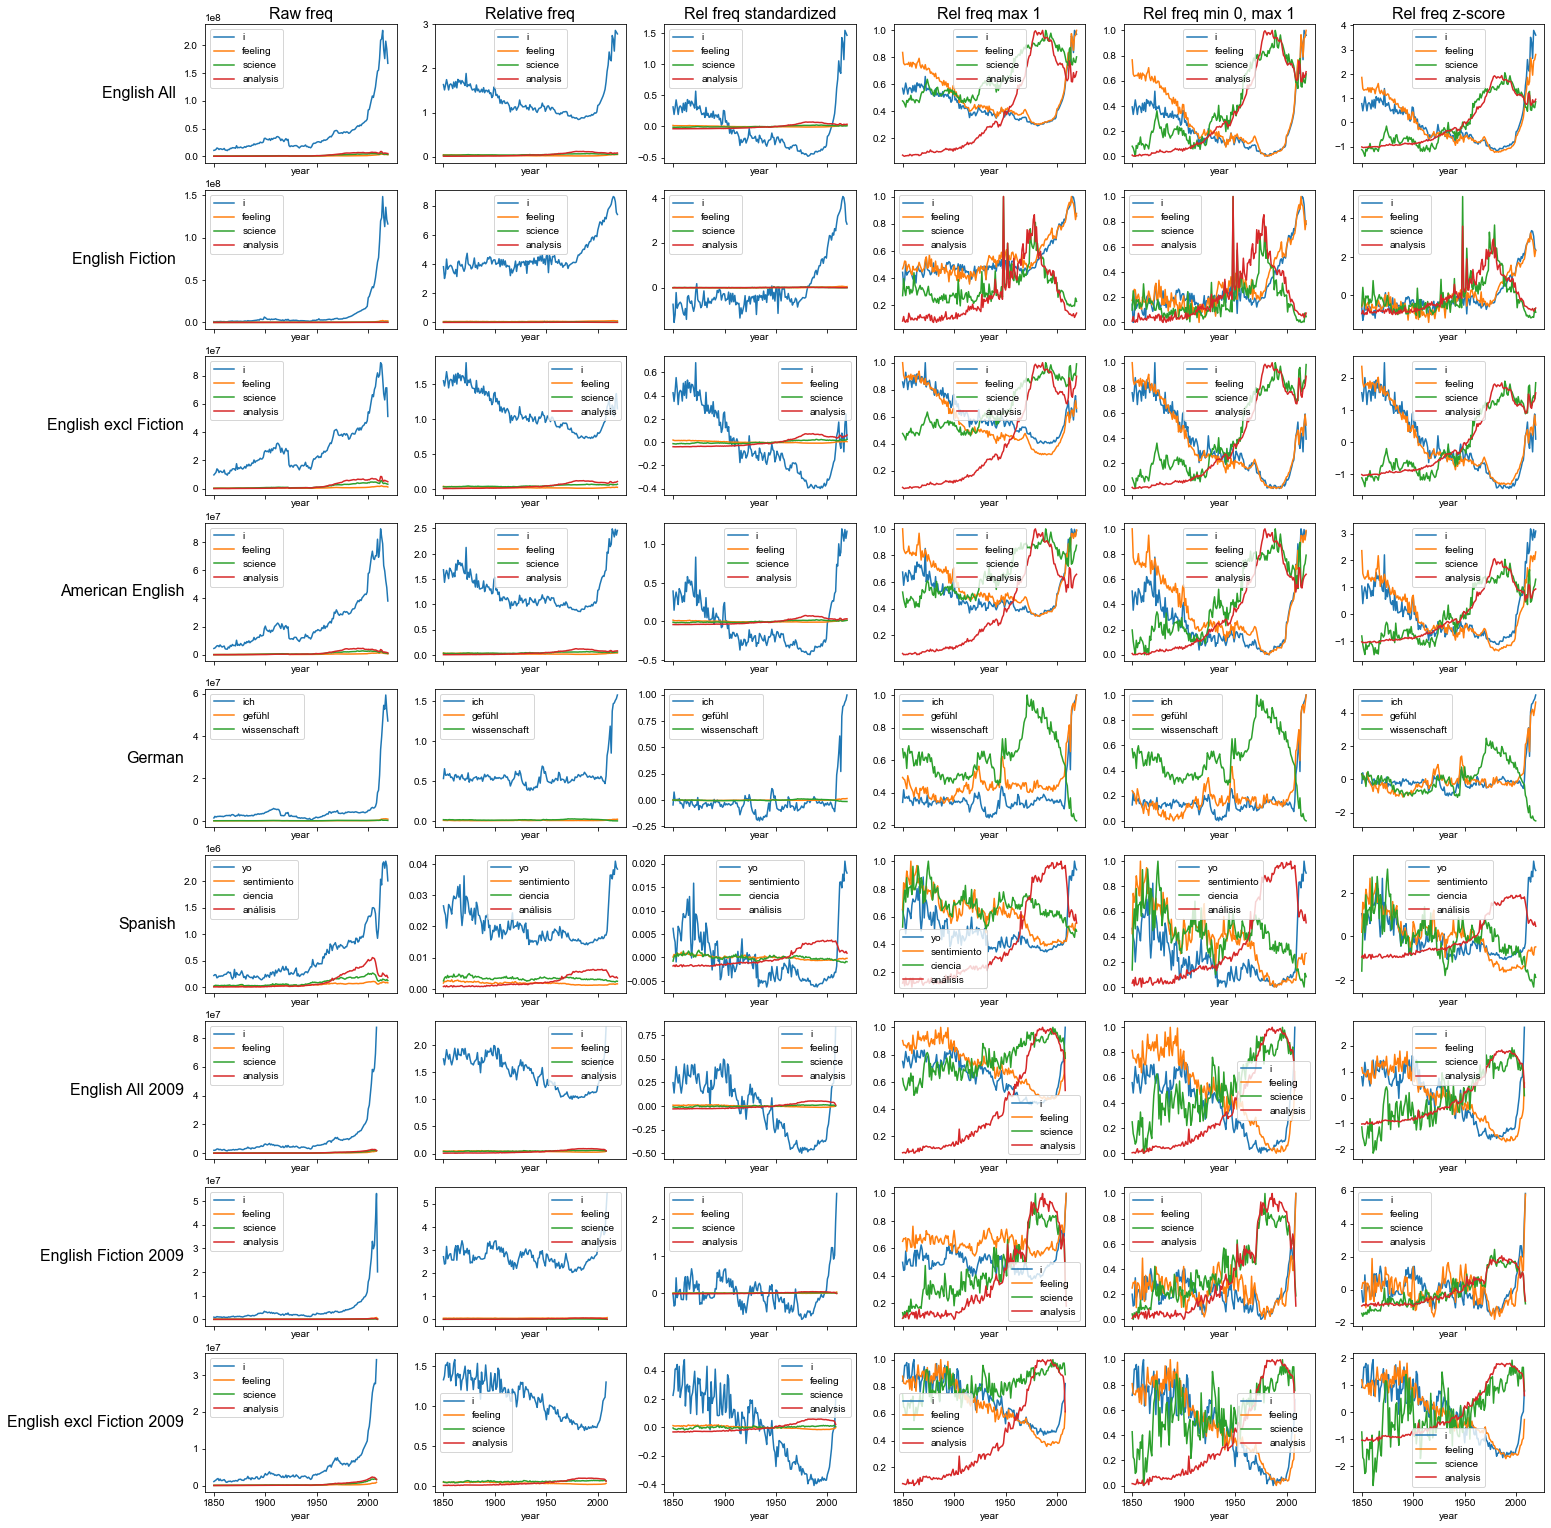

In [11]:
words={'eng':['i', 'feeling','science', 'analysis'], 
       'ger':['ich', 'gefühl', 'wissenschaft'], 
       'sp': ['yo', 'sentimiento','ciencia', 'análisis']}
frows = len(categories)
fcols = len(methods)
fig, axs = plt.subplots(frows,fcols, figsize=(4*fcols,3*frows), sharex=True)
i=0
for corpus, row in categories.iterrows():
    for j, method in enumerate(methods):
        axs[i,j].plot(ts[corpus, method][words[row.lan]])
        axs[i,j].set_xlabel('year')
        axs[i,j].legend(words[row.lan])
        # set title to row
        if i==0:
            axs[i,j].annotate(method_titles[j], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=16, ha='center', va='baseline')
        if j==0:  
            axs[i,j].annotate(row.title, xy=(0, 0.5), xytext=(-axs[i,j].yaxis.labelpad - 0.5, 0),
                    xycoords=axs[i,j].yaxis.label, textcoords='offset points',
                    fontsize=16, ha='right', va='center')
    i=i+1

  

### pickle data

In [12]:
pd.to_pickle(ts, 'ngrams5000_ts.pkl')
pd.to_pickle(tssent, 'ngrams5000_tssent.pkl')
pd.to_pickle(tsPCA, 'ngrams5000_tsPCA.pkl')
pd.to_pickle(wordPCA, 'ngrams5000_wordPCA.pkl')
pd.to_pickle(PCA_expl_var, 'ngrams5000_PCA_expl_var.pkl')

## New York Times 

### Define function to deal with NYT data

In [13]:
def NYT_get_data(method, scaleword):
    # create a scaler object
    minmax_scaler = MinMaxScaler()
    # load data
    with open('NYT/NYT_data.pkl', 'rb') as f:
        data_pkl = pickle.load(f)
    df = pd.DataFrame.from_dict(data_pkl)
    df.index.name= 'date'
    df = df.replace(0,np.nan) 
    df = df.fillna(value=np.nan)
    # drop columns with only Nans
    df= df.dropna(axis=1, how='all')
    # drop duplicates
    df = df.drop_duplicates()
    # sort index on date
    df = df.sort_index()
    if method != 'raw':
        # divide all frequencies by scaleword
        df = df.div(df[scaleword], axis =0)
        if method == 'z':
            # calculate z-scores for each word
            df = (df - df.mean()) / df.std() 
            print('method = data scaled to', scaleword, 'z-scores')
        elif method == 'mean':
            df = (df - df.mean())
            print('method = data scaled to', scaleword, 'data - mean')
        elif method == '01':
            # scale data between 0 and 1
            df = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns, index=df.index)
            print('method = data scaled to', scaleword, 'scaled between 0 and 1')
        elif method == 'max1':
            df = (df / df.max()) 
            print('method = data scaled to total frequency, data / max')
        elif method == 'scaled':
            print('method = data scaled to', scaleword, 'no standardization')
        else:
            print('no appropiate method given')
            
    else:
        print('raw data used, no scaling, no standardization')
    return df

In [14]:
# add NYT data to ts dictionary 
for method in methods:
    ts['NYT', method]= NYT_get_data(method=method, scaleword="")

raw data used, no scaling, no standardization
method = data scaled to  no standardization
method = data scaled to  data - mean
method = data scaled to total frequency, data / max
method = data scaled to  scaled between 0 and 1
method = data scaled to  z-scores


### Use  empty word ("") as scaleword. 
Words like 'the' and 'an' are problematic, because they give 0's in certain timeframes. Searches with an empty word follow the same frequency pattern as 'the', therefore we use '' as the scaleword. 

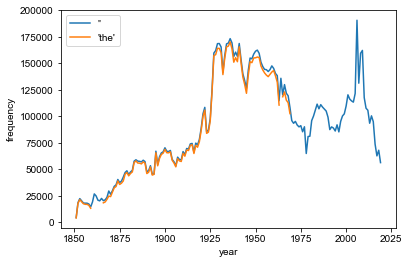

In [16]:
# Check timeseries for ''  and for 'the':
lan='eng'
words=['','the']
method= 'raw'
plt.plot(ts['NYT', method][words])
plt.xlabel('year')
plt.ylabel('frequency')
plt.legend(['\'\'','\'the\''])

### Visually check timeseries for some words in NYT data

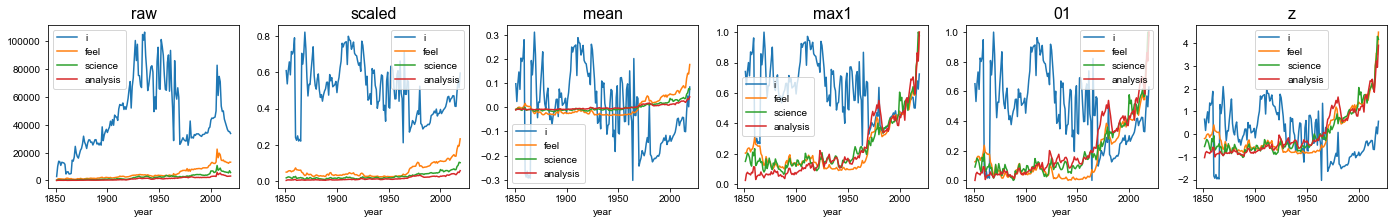

In [17]:
lan='eng'
words=['i', 'feel','science', 'analysis']
plt.figure(figsize=(len(methods)*4, 3))
for i, method in enumerate(methods):
    #print('mean: ', np.round(np.mean(tsNYT[method][words]),3))
    #print('std: ', np.round(np.std(tsNYT[method][words]),3))
    plt.subplot(1,len(methods),i+1)    
    plt.plot(ts['NYT', method][words])
    plt.title(method, fontsize = 16)
    plt.xlabel('year')
    plt.legend(words)
    

### Pickle updated data

In [18]:
pd.to_pickle(ts, 'ts_all.pkl')

## Google Trends - annual means
Google Trends normalizes search data to make comparisons between terms easier. Search results are normalized to the time and location of a query by the following process:

* Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity. Otherwise, places with the most search volume would always be ranked highest.

* The resulting numbers are then scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics.

* Different regions that show the same search interest for a term don't always have the same total search volumes.

GT data is already scaled to total searches, do we don't do any scaling 
We use monthly data, and calculate annual means

### Define function to deal with GT data

In [19]:
# Use annual means for Google Trends
def GT_get_data(df, lan, rmwords, sent, method):
    # create a scaler object
    minmax_scaler = MinMaxScaler()   
    # drop removewords
    df = df.drop(columns=rmwords,  errors='ignore')
    # drop duplicates
    df = df.drop_duplicates()
    # sort index on date
    df = df.sort_index()
    if method != 'raw':
        # calculate annual means
        df = df.groupby([df.index.year]).mean()
        if method != 'am':
            if method == 'z':
                # calculate z-scores for each word
                df = (df - df.mean()) / df.std() 
                print('method = z-scores')
            elif method == 'mean':
                df = (df - df.mean())
                print('method = data - mean')
            elif method == '01':
                # scale data between 0 and 1
                df = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns, index=df.index)
                print('method = scaled between 0 and 1')
            elif method == 'max1':
                df = (df / df.max()) 
                print('method = data scaled to total frequency, data / max')
            else:
                print('no appropiate method given')
        else:
            print('annual means, no standardization')
            
    else:
        print('raw data, no annual means, no standardization')
    
    # Make long format dataframe from original data 
    df_long=df.transpose()
    s = df_long.stack(0)
    s.name= 'freq'
    df_long= s.reset_index()
    df_long.columns=['word','date','freq']
    df_longsent= pd.merge(df_long, sent, how="inner", on='word')

    # create ts sent
    ts_sent=pd.DataFrame(
        {'sent_pos': df_longsent[df_longsent['ValMN'] >= 0].groupby('date').apply(lambda s: sum(s["freq"]*abs(s["ValMN"]))),
         'sent_neg': df_longsent[df_longsent['ValMN'] < 0].groupby('date').apply(lambda s: sum(s["freq"]*abs(s["ValMN"]))),
         'sent_aro': df_longsent.groupby('date').apply(lambda s: sum(s["freq"]*abs(s["AroMN"])))})

    return df, ts_sent

### Methods GT

In [20]:
methods_GT=['raw', 'am', 'mean', 'max1','01', 'z']
method_titles_GT=['Raw freq', 'Annual means', 'Annual means standardized', 'Annual means max 1','Annual means min 0, max 1', 'Annual means z-score']

### Corpora GT

In [21]:
# different corpora GT
corporaGT = ['GT_eng_all', 'GT_eng_am','GT_ger','GT_sp']
languagesGT = ['eng', 'eng', 'ger', 'sp']
rmwordsGT=[]
for lan in languagesGT:
    if lan == 'eng':
        rmwordsGT.append(['war', 'date'])
    elif lan == 'ger':
        rmwordsGT.append(['krieg'])
    elif lan == 'sp':
        rmwordsGT.append(['guerra'])
    else:
        print('Language: ', lan, ' unknown')
titlesGT = ['English All','American English','German','Spanish']
categoriesGT = pd.DataFrame(
    {'corpora': corporaGT,
     'lan': languagesGT,
     'rmwords' : rmwordsGT,
     'title': titlesGT})
lans_uniqueGT = categoriesGT['lan'].unique()
categoriesGT = categoriesGT.set_index('corpora')
categoriesGT

,lan,rmwords,title
corpora,,,
GT_eng_all,eng,"[war, date]",English All
GT_eng_am,eng,"[war, date]",American English
GT_ger,ger,[krieg],German
GT_sp,sp,[guerra],Spanish


### Calculate timeseries GT

In [22]:
for corpus, row in categoriesGT.iterrows():
    print ('corpus = ', corpus)
    lan = row.lan
    print ('language = ', lan)
    df = pd.read_pickle("GT/"+corpus +".pkl")
    df_5000 = df[[word for word in df.columns if word in allwords[lan]]]
    for method in methods_GT:
        ts[corpus, method], tssent[corpus, method]=\
        GT_get_data(df=df_5000, lan=lan, rmwords=row.rmwords, sent=sent[lan], method=method)

corpus =  GT_eng_all
language =  eng
raw data, no annual means, no standardization
annual means, no standardization
method = data - mean
method = data scaled to total frequency, data / max
method = scaled between 0 and 1
method = z-scores
corpus =  GT_eng_am
language =  eng
raw data, no annual means, no standardization
annual means, no standardization
method = data - mean
method = data scaled to total frequency, data / max
method = scaled between 0 and 1
method = z-scores
corpus =  GT_ger
language =  ger
raw data, no annual means, no standardization
annual means, no standardization
method = data - mean
method = data scaled to total frequency, data / max
method = scaled between 0 and 1
method = z-scores
corpus =  GT_sp
language =  sp
raw data, no annual means, no standardization
annual means, no standardization
method = data - mean
method = data scaled to total frequency, data / max
method = scaled between 0 and 1
method = z-scores


In [23]:
ts['GT_eng_all', 'raw']

,you,i,the,to,s,a,it,t,that,and,...,spice,iris,representative,historical,stalking,madman,acceptable,gravy,pains,impulse
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,26,49,95,46,48,47,40,62,39,100,...,39,52,85,94,29,74,74,14,29,76
2004-02-01,27,48,100,46,48,48,40,64,41,100,...,41,65,94,100,19,77,70,17,39,76
2004-03-01,27,48,97,46,46,50,40,62,40,96,...,43,61,92,95,26,50,70,17,41,69
2004-04-01,27,49,96,46,46,49,40,65,41,99,...,42,65,74,96,22,58,69,13,49,80
2004-05-01,27,48,93,44,49,48,41,63,40,91,...,37,69,71,87,29,45,83,15,41,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,77,87,81,98,78,93,78,89,83,78,...,46,56,64,25,66,40,73,48,52,38
2020-09-01,77,85,90,95,84,97,77,85,100,84,...,47,52,75,30,57,36,89,46,50,44
2020-10-01,75,83,86,93,80,95,80,85,95,80,...,47,50,74,27,51,41,82,55,51,46


### Visually check timeseries GT

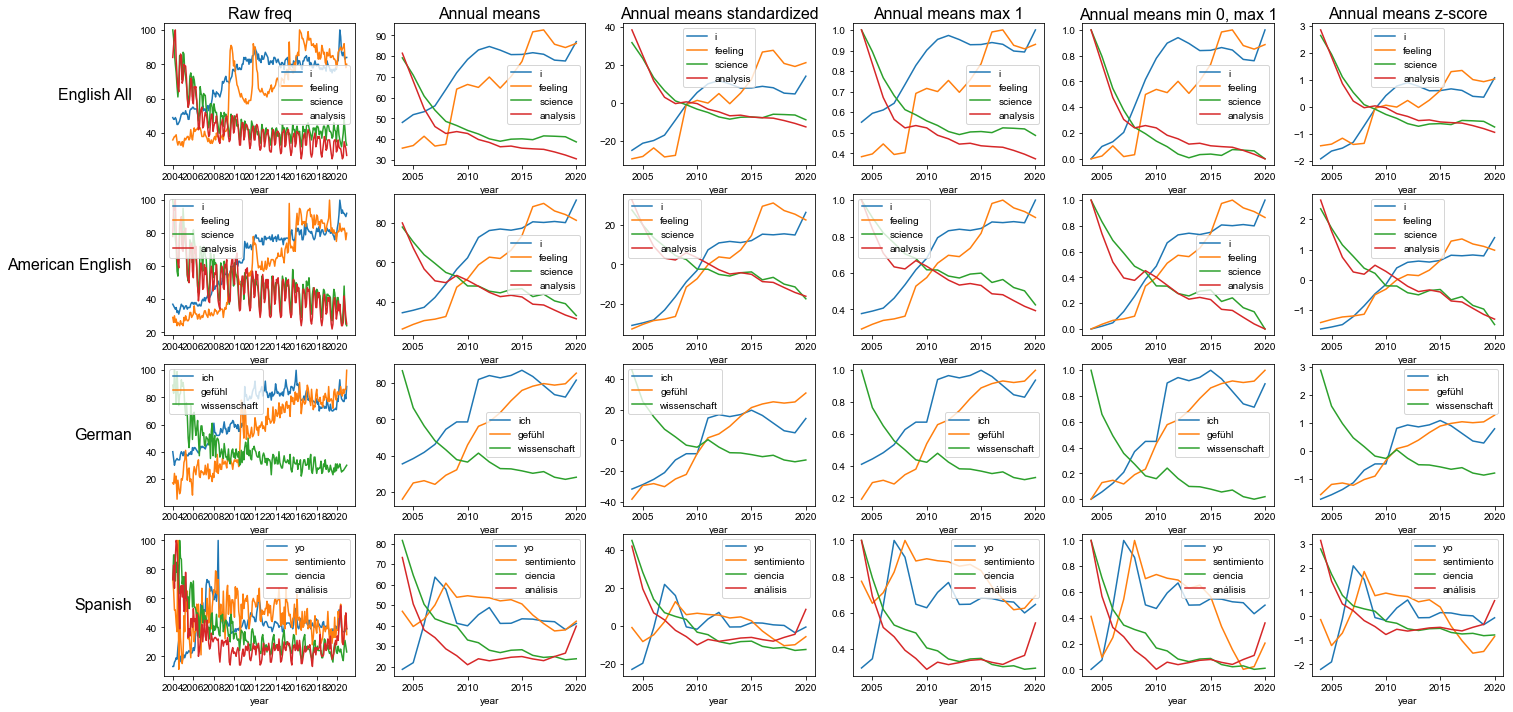

In [24]:
words={'eng':['i', 'feeling','science', 'analysis'], 
       'ger':['ich', 'gefühl', 'wissenschaft'], 
       'sp': ['yo', 'sentimiento','ciencia', 'análisis']}
frows = len(categoriesGT)
fcols = len(methods_GT)
fig, axs = plt.subplots(frows,fcols, figsize=(4*fcols,3*frows))
i=0
for corpus, row in categoriesGT.iterrows():
    for j, method in enumerate(methods_GT):
        axs[i,j].plot(ts[corpus, method][words[row.lan]])
        axs[i,j].set_xlabel('year')
        axs[i,j].legend(words[row.lan])

        # set title to row
        if i==0:
            axs[i,j].annotate(method_titles_GT[j], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=16, ha='center', va='baseline')
        if j==0:  
            axs[i,j].annotate(row.title, xy=(0, 0.5), xytext=(-axs[i,j].yaxis.labelpad - 0.5, 0),
                    xycoords=axs[i,j].yaxis.label, textcoords='offset points',
                    fontsize=16, ha='right', va='center')
    i=i+1



### pickle updated data

In [25]:
pd.to_pickle(ts, 'ts_all.pkl')
pd.to_pickle(tssent, 'tssent_all.pkl')

## Correlations ngrams - Google Trends

### Overlapping words

In [26]:
ts = pd.read_pickle('ts_all.pkl')
method='z'
corpora_ngrams = ['eng_all', 'eng_fic', 'eng_excl_fic','eng_am','ger','sp']
corpora_GT = ['GT_eng_all', 'GT_eng_all', 'GT_eng_all','GT_eng_am','GT_ger','GT_sp']
words_overlap={}
ts_ngrams={}
ts_GT={}
for corpus_ng, corpus_GT in zip(corpora_ngrams, corpora_GT): 
    # select overlapping years
    ts_ngrams[corpus_ng, method]= ts[corpus_ng,method][ts[corpus_ng,method].index.isin(ts[corpus_GT, method].index)]
    ts_GT[corpus_GT,method] = ts[corpus_GT, method][ts[corpus_GT, method].index.isin(ts_ngrams[corpus_ng, method].index)]
    # check overlapping words
    words_overlap[corpus_ng] = np.intersect1d(ts_GT[corpus_GT, method].columns, ts_ngrams[corpus_ng, method].columns)
    print("overlapping words", corpus_ng, corpus_GT)
    print(len(words_overlap[corpus_ng]))

overlapping words eng_all GT_eng_all
4995
overlapping words eng_fic GT_eng_all
4995
overlapping words eng_excl_fic GT_eng_all
4995
overlapping words eng_am GT_eng_am
4995
overlapping words ger GT_ger
4231
overlapping words sp GT_sp
4988


### Calculate Spearman correlation between ngrams and GT 
For overlapping years and overlapping words

In [27]:
df_corr={}
for corpus_ng, corpus_GT in zip(corpora_ngrams, corpora_GT): 
    words=[]
    corrcoeff=[]
    pval=[]
    for word in words_overlap[corpus_ng]:
        words.append(word)
        c,p = scipy.stats.spearmanr(ts_ngrams[corpus_ng, method][word],ts_GT[corpus_GT, method][word])
        corrcoeff.append(c)
        pval.append(p)
    df_corr[corpus_ng, method]= pd.DataFrame(list(zip(words,corrcoeff, pval)), columns = ['word', 'corrcoeff', 'pval'])

### pickle data

In [28]:
pd.to_pickle(df_corr, 'corr_coeff_ngrams_GT.pkl')

### Distribution of correlations

Percentage positive correlations =
0.6392392392392392
Average correlations coefficient=
0.19684196500633877
Percentage positive correlations =
0.6056056056056056
Average correlations coefficient=
0.11840897198121096
Percentage positive correlations =
0.6048048048048048
Average correlations coefficient=
0.12360658218770999
Percentage positive correlations =
0.6984984984984985
Average correlations coefficient=
0.2875656532881202
Percentage positive correlations =
0.6364925549515481
Average correlations coefficient=
0.2059721197695946
Percentage positive correlations =
0.6461507618283882
Average correlations coefficient=
0.22124817374049174


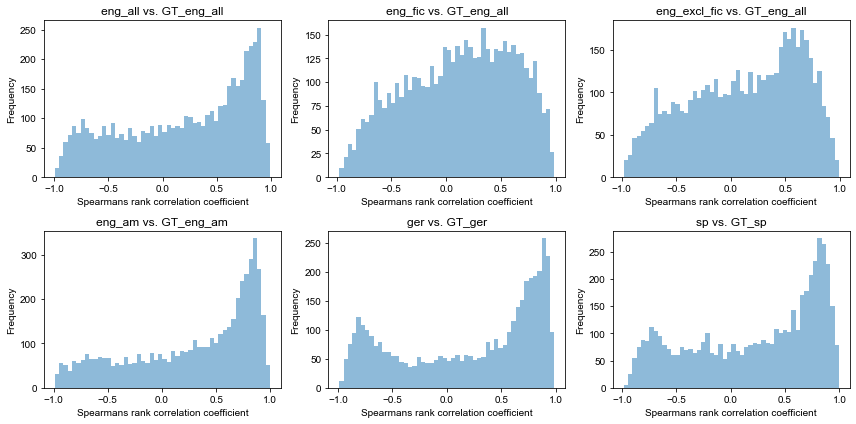

In [29]:
# print and plot output
plt.figure(figsize=(len(corpora_ngrams)*2, 6))
i=0
for corpus_ng, corpus_GT in zip(corpora_ngrams, corpora_GT): 
    title_plot= corpus_ng + ' vs. ' + corpus_GT
    i=i+1
    print("Percentage positive correlations =")
    print(sum(df_corr[corpus_ng,method].corrcoeff>0)/len(words_overlap[corpus_ng]))
    print("Average correlations coefficient=")
    print(sum(df_corr[corpus_ng,method].corrcoeff)/len(words_overlap[corpus_ng]))
    plt.subplot(2,int(len(corpora_ngrams)/2),i)    
    plt.hist(df_corr[corpus_ng,method].corrcoeff, bins=50, alpha=0.5)
    plt.title(title_plot)
    plt.xlabel('Spearmans rank correlation coefficient')
    plt.ylabel('Frequency')
plt.tight_layout()

### Bootstrap analysis

In [30]:
from tqdm import tqdm

In [42]:
# only run first time! 
"""
bootstrap_matrix={}
corpora_ngrams = ['eng_all', 'eng_fic', 'eng_excl_fic','eng_am','ger','sp']
for corpus in corpora_ngrams: 
    bootstrap_matrix[corpus]=[]
with open('bootstrap_matrix.pkl', 'wb') as f:
    pickle.dump(bootstrap_matrix, f)
"""


### Perform bootstrap analysis for all corpora

In [43]:
with open('bootstrap_matrix.pkl', 'rb') as f:
    bootstrap_matrix = pickle.load(f)
nruns=1000
corpora_ngrams = ['eng_all', 'eng_fic', 'eng_excl_fic','eng_am','ger','sp']
corpora_GT = ['GT_eng_all', 'GT_eng_all', 'GT_eng_all','GT_eng_am','GT_ger','GT_sp']
for corpus, corpus_GT in zip(corpora_ngrams, corpora_GT):  
    print(corpus)
    with tqdm(total=nruns-len(bootstrap_matrix[corpus])) as pbar:
        while (len(bootstrap_matrix[corpus])<nruns):
            pbar.update()
            corrcoeff=[]
            pval=[]
            for word1 in words_overlap[corpus]:
                word2 = random.choice(words_overlap[corpus])
                c,p = scipy.stats.spearmanr(ts_ngrams[corpus,method][word1],ts_GT[corpus_GT,method][word2])
                corrcoeff.append(c)
                pval.append(p)
            bootstrap_matrix[corpus].append(corrcoeff)
        with open('bootstrap_matrix.pkl', 'wb') as f:
            pickle.dump(bootstrap_matrix, f)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

eng_all


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

eng_fic


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

eng_excl_fic


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

eng_am


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

ger


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

sp


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:03<00:00,  2.70s/it]
